# **Modeling and Forecasting Stock Volatility on the Johannesburg Stock Exchange: GARCH Approach**

In [6]:
pip install yfinance arch statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 13.5 MB/s eta 0:00:00


In [7]:
#import liabraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm

** Downloading and loading data from yahoo finance**

In [8]:


# Parameters
import yfinance as yf

df = yf.download("SBK.JO", start="2015-01-01", end="2025-01-01")
print(df.head())




/tmp/ipython-input-1366290968.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SBK.JO", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open   Volume
Ticker            SBK.JO        SBK.JO        SBK.JO        SBK.JO   SBK.JO
Date                                                                       
2015-01-01  14258.891602  14258.891602  14258.891602  14258.891602        0
2015-01-02  14137.650391  14386.097783  14079.016806  14211.190819  1618581
2015-01-05  13441.997070  14135.662156  13441.997070  14081.997522  3182810
2015-01-06  13972.680664  14015.413613  13446.966007  13485.723799  2934716
2015-01-07  14294.667969  14294.667969  13808.704910  13887.214279  2548467


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2527 entries, 2015-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, SBK.JO)   2527 non-null   float64
 1   (High, SBK.JO)    2527 non-null   float64
 2   (Low, SBK.JO)     2527 non-null   float64
 3   (Open, SBK.JO)    2527 non-null   float64
 4   (Volume, SBK.JO)  2527 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.5 KB


**Rindex df and standardize columns**

In [10]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
# Remove the ticker suffix from column names
df.columns = [col.split('_')[0].lower() for col in df.columns]
print(df.columns)



Index(['close', 'high', 'low', 'open', 'volume'], dtype='object')


# **Explatory Data Analyis(EDA)**

**Compute daily returns**

In [11]:
df['return'] = df['close'].pct_change() * 100
df = df.dropna(subset=['return'])
returns = df['return'].dropna()
print(df[['return']].head())




              return
Date                
2015-01-02 -0.850285
2015-01-05 -4.920572
2015-01-06  3.947952
2015-01-07  2.304406
2015-01-08  1.501666


**Compute daily volatilty **

In [ ]:
import pandas as pd
import numpy as np

# Overall daily volatility (single value)
daily_vol = returns.std()
print("Type of daily_vol:", type(daily_vol))
print("Overall daily volatility (%):", round(daily_vol, 4))


Type of daily_vol: <class 'float'>
Overall daily volatility (%): 1.9978


**Compute Anual volatility**

In [ ]:
# Annualized volatility
annual_vol = daily_vol * np.sqrt(252)  # 252 trading days per year
print("Annualized volatility (%):", round(annual_vol, 4))


Annualized volatility (%): 31.7418


**Calculating the rolling volatility for the SBK, using a 50-day window.**

In [ ]:
rolling_50d_volatility =returns.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(rolling_50d_volatility))
print("rolling_50d_volatility shape:",rolling_50d_volatility.shape)
rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2475,)


,return
Date,
2015-03-16,1.771463
2015-03-17,1.702716
2015-03-18,1.684613
2015-03-19,1.674772
2015-03-20,1.640529


**Create a time series line plot **

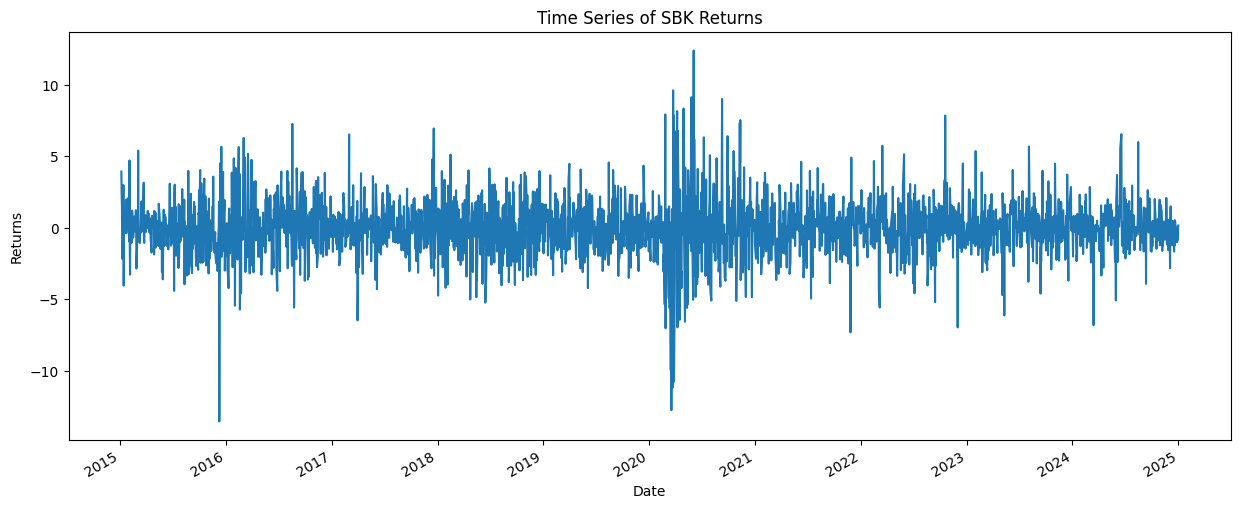

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 6))
# Plot returns `
returns.plot(ax=ax)
# Label axes
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Time Series of SBK Returns");

**Creating a histogram y_ambuja with 25 bins.**

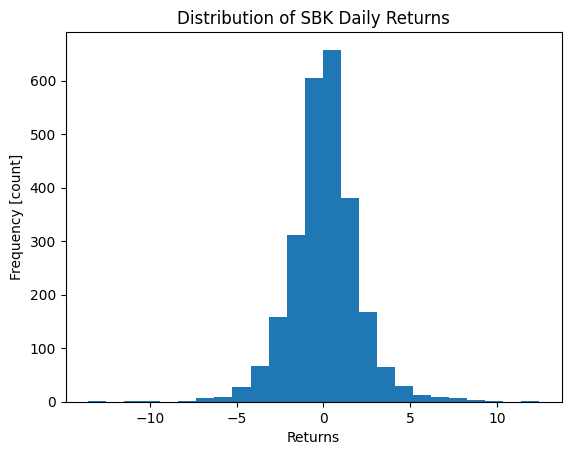

In [ ]:
# Create histogram of `y_ambuja`, 25 bins
plt.hist(returns, bins=25)
# Add axis labels
plt.xlabel("Returns")
plt.ylabel("Frequency [count]")
# Add title
plt.title("Distribution of SBK Daily Returns");

Creating an ACF plot of the squared returns for SBK BY labeling x-axis as "Lag [days]", the y-axis as "Correlation Coefficient", and  title  as "ACF of SBK Squared Returns".

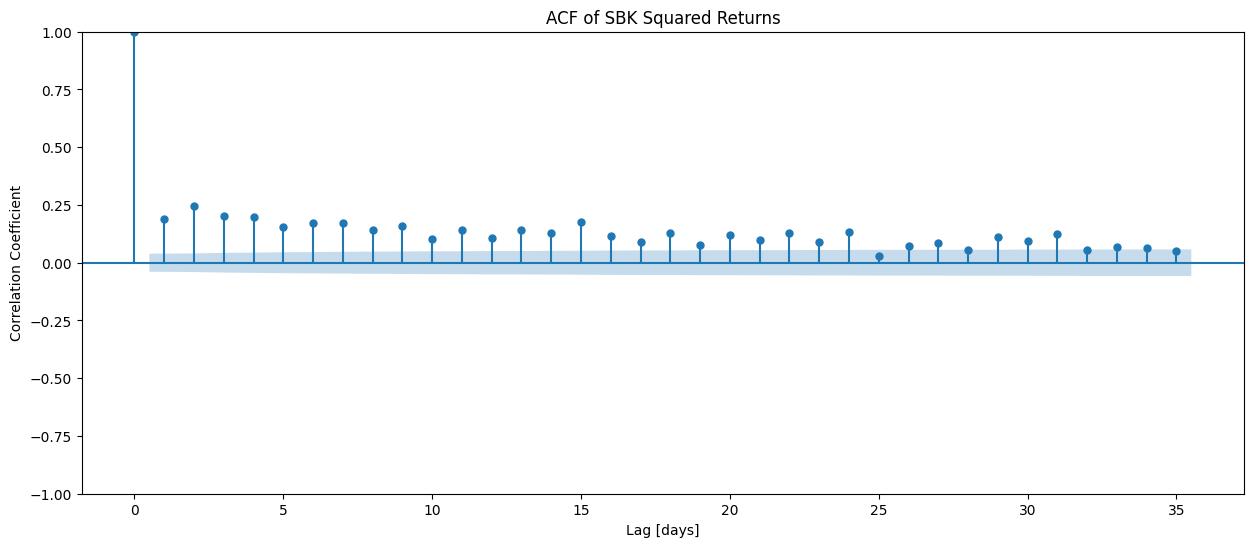

In [ ]:
# Create `fig` and `ax`
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(returns**2, ax=ax)
# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("ACF of SBK Squared Returns");

Creating a PACF plot of the squared returns for SBK by making x-axis  as "Lag [days]", the y-axis as "Correlation Coefficient", and the title as  "PACF of SBK Squared Returns".

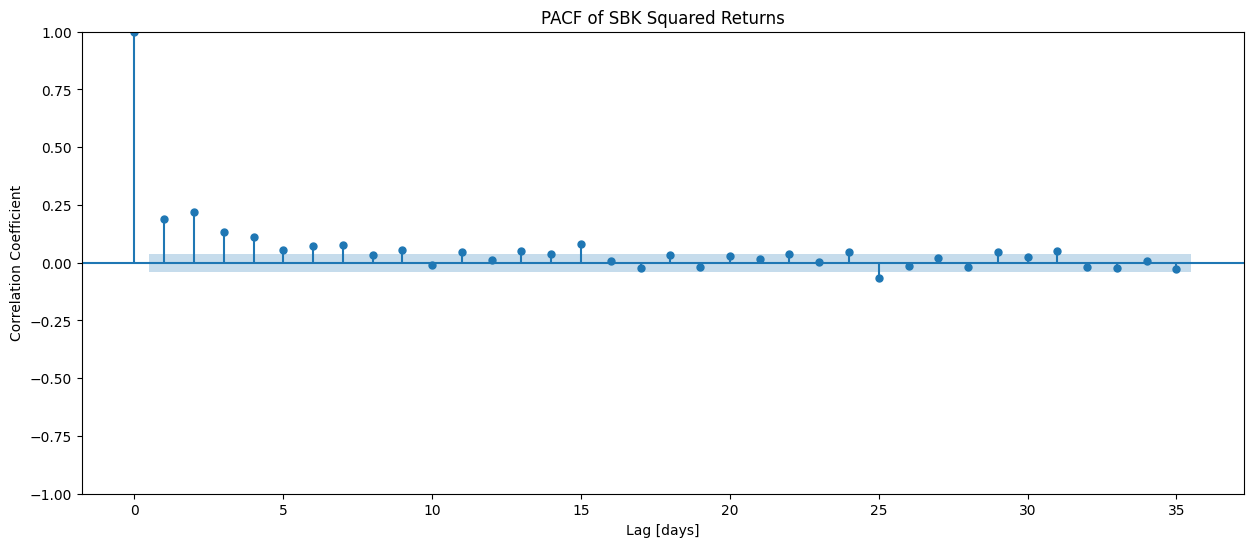

In [ ]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(returns **2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
# Add title
plt.title("PACF of SBK Squared Returns");

# **Spliting training and Test Data**

**Setting training and testing data**
Training data= 80% of sample and test data= 20%

In [13]:
cutoff_test = int(len(returns)*0.8)
y_train = returns.iloc[:cutoff_test]

print("y_train type:", type(y_train))
print("y_train shape:", y_train.shape)
y_train.head()

y_train type: <class 'pandas.core.series.Series'>
y_train shape: (2020,)


,return
Date,
2015-01-02,-0.850285
2015-01-05,-4.920572
2015-01-06,3.947952
2015-01-07,2.304406
2015-01-08,1.501666


# **Build and fit a GARCH model**

In [14]:
from arch import arch_model
# Build and train model
model = arch_model(
    y_train,
    p=1,
    q=1,
    rescale=False


).fit(disp=0)
print("model type:", type(model))
# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4207.53
Distribution:                  Normal   AIC:                           8423.06
Method:            Maximum Likelihood   BIC:                           8445.50
                                        No. Observations:                 2020
Date:                Wed, Oct 01 2025   Df Residuals:                     2019
Time:                        12:42:16   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0490  4.039e-02      1.213      0.225 [-3.017e-02,  0.128]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1186  6.386e-02      1.857  6.331e-02 [-6.574e-03,  0.244]
alpha[1]       0.0591  2.143e-02      2.760  5.779e-03  [1.714e-02,  0.101]
beta[1]        0.9118  3.355e-02     27.180 1.129e-162    [  0.846,  0.978]
===========================================================================

Covariance estimator: robust
"""

**Comparing GARCH(1,1) and GARCH(2,2)**

In [ ]:

from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

# Fit GARCH(1,1)
g11 = arch_model(returns, mean='Zero', vol='Garch', p=1, q=1, dist='normal').fit(disp='off')
# Fit GARCH(2,2)
g22 = arch_model(returns, mean='Zero', vol='Garch', p=2, q=2, dist='normal').fit(disp='off')

print("---- AIC/BIC ----")
print("GARCH(1,1): AIC", g11.aic, " BIC", g11.bic)
print("GARCH(2,2): AIC", g22.aic, " BIC", g22.bic)

print("\n---- Parameter significance (summary) ----")
print("GARCH(1,1)\n", g11.summary())
print("\nGARCH(2,2)\n", g22.summary())

# Stationarity check
sum11 = g11.params.get('alpha[1]',0) + g11.params.get('beta[1]',0)
sum22 = sum([v for k,v in g22.params.items() if k.startswith('alpha')]) + sum([v for k,v in g22.params.items() if k.startswith('beta')])
print("\nSum alpha+beta (1,1):", sum11, "  (2,2):", sum22)

# Residual diagnostics: Ljung-Box on squared standardized residuals
std_resid11 = g11.std_resid.dropna()
std_resid22 = g22.std_resid.dropna()

lb11 = acorr_ljungbox(std_resid11**2, lags=[10], return_df=True)
lb22 = acorr_ljungbox(std_resid22**2, lags=[10], return_df=True)
print("\nLjung-Box (squared resid) p-values at lag10:")
print("GARCH(1,1):", lb11['lb_pvalue'].values[0])
print("GARCH(2,2):", lb22['lb_pvalue'].values[0])

# Simple out-of-sample rolling 1-step forecast comparison (fast version)
def rolling_forecast(model_spec, returns, start_window=1000):
    n = len(returns)
    forecasts = []
    true_var = []
    for t in range(start_window, n-1):
        train = returns.iloc[:t]
        m = arch_model(train, **model_spec).fit(disp='off')
        f = m.forecast(horizon=1, reindex=False).variance.values[-1,0]
        forecasts.append(f)            # variance forecast (squared % units if input in %)
        true_var.append(returns.iloc[t+1]**2)  # realized proxy
    return np.array(forecasts), np.array(true_var)

spec11 = {'mean':'Zero','vol':'Garch','p':1,'q':1,'dist':'normal'}
spec22 = {'mean':'Zero','vol':'Garch','p':2,'q':2,'dist':'normal'}

fc11, rv11 = rolling_forecast(spec11, returns, start_window=800)
fc22, rv22 = rolling_forecast(spec22, returns, start_window=800)

print("\nOut-of-sample MSE on variance forecasts:")
print("GARCH(1,1):", mean_squared_error(rv11, fc11))
print("GARCH(2,2):", mean_squared_error(rv22, fc22))


---- AIC/BIC ----
GARCH(1,1): AIC 10296.217914288416  BIC 10313.7187149594
GARCH(2,2): AIC 10298.077357431606  BIC 10327.245358549912

---- Parameter significance (summary) ----
GARCH(1,1)
                        Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5145.11
Distribution:                  Normal   AIC:                           10296.2
Method:            Maximum Likelihood   BIC:                           10313.7
                                        No. Observations:                 2524
Date:                Wed, Oct 01 2025   Df Residuals:                     2524
Time:                        09:29:28   Df Model:                            0
                              Volatility Model                              
                 coef 

Between GARCH(1,1) and GARCH(2,2), the GARCH(1,1) specification was selected based on lower AIC/BIC values, more parsimonious parameterization, and superior out-of-sample forecast performance. While GARCH(2,2) marginally improved residual diagnostics, its additional parameters were not consistently significant, and forecast accuracy worsened slightly. Hence, GARCH(1,1) provides the most appropriate balance between model fit and interpretability.

# **Evaluate**

```
# This is formatted as code
```



**Ploting the standardized residuals for the model.**

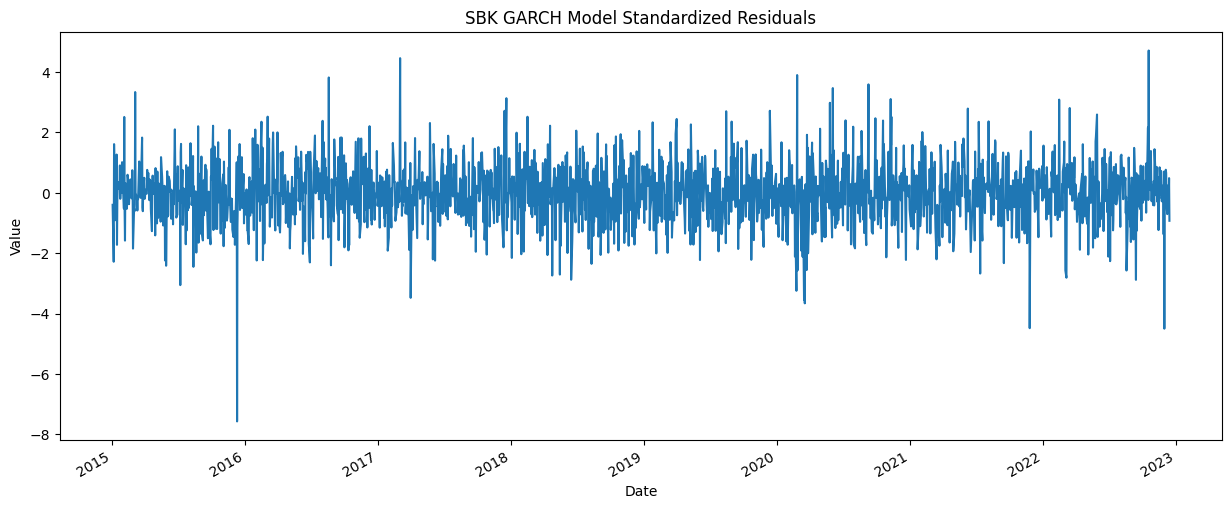

In [ ]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))
# Plot standardized residuals
model.std_resid.plot(ax=ax )
# Add axis labels
plt.xlabel("Date")
plt.ylabel("Value")
# Add title
plt.title("SBK GARCH Model Standardized Residuals");

**Createing an ACF plot of the squared, standardized residuals of the model.**

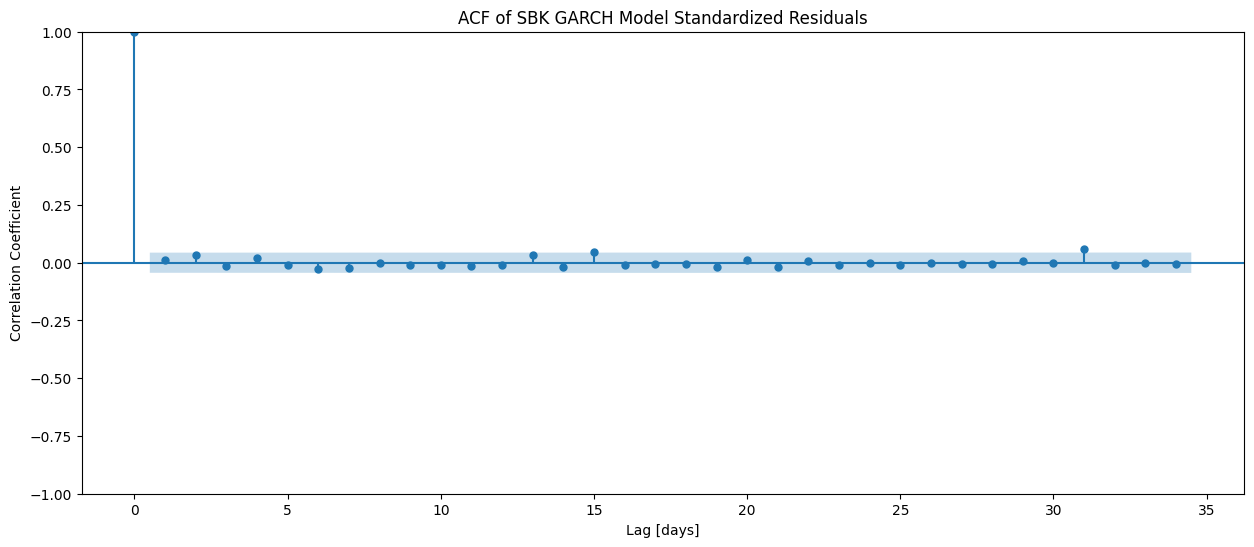

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)
# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("ACF of SBK GARCH Model Standardized Residuals");

** *italicized text*Doing walk-forward validation on your model.**

In [15]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(returns) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = returns.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1,q=1,rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0]**0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=returns.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (505,)


,0
Date,
2022-12-20,2.113621
2022-12-21,2.076347
2022-12-22,2.012395
2022-12-23,1.958409
2022-12-28,1.903547


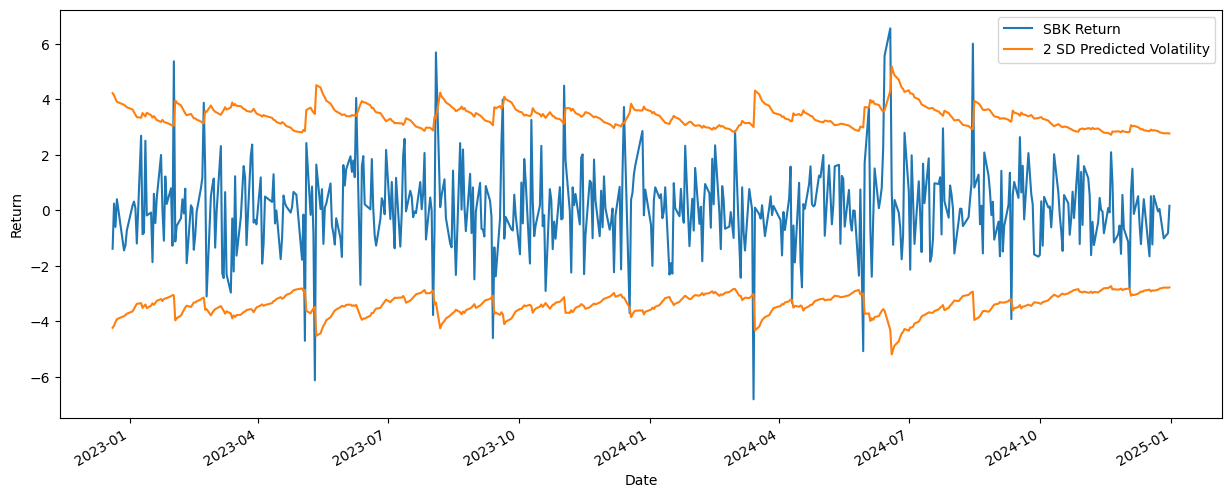

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
returns.tail(test_size).plot(ax=ax, label="SBK Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

# **Communicating The Results**

**Forecasting**

In [18]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)
# Forecast horizon = number of columns
n_periods = prediction.shape[1]

# Forecast start date (day after the last observation)
start = prediction.index[0] + pd.DateOffset(days=1)
# Create date range
prediction_dates = pd.bdate_range(start=start, periods=n_periods)
# Convert to ISO 8601 strings
prediction_index = [d.isoformat() for d in prediction_dates]
print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
print("First 3 prediction dates:", prediction_index[:3])
# (Optional) assign these as column labels
prediction.columns = prediction_index
print(prediction)


                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2024-12-30  1.386505  1.402551  1.418001  1.432886  1.447234
prediction_index type: <class 'list'>
prediction_index len: 5
First 3 prediction dates: ['2024-12-31T00:00:00', '2025-01-01T00:00:00', '2025-01-02T00:00:00']
            2024-12-31T00:00:00  2025-01-01T00:00:00  2025-01-02T00:00:00  \
Date                                                                        
2024-12-30             1.386505             1.402551             1.418001   

            2025-01-03T00:00:00  2025-01-06T00:00:00  
Date                                                  
2024-12-30             1.432886             1.447234  


**Creating a clean_prediction function**

In [20]:
def clean_prediction(prediction):
    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days=1)

    # Horizon is number of columns (ARCH variance is shape (1, horizon))
    horizon = prediction.shape[1]
    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=horizon)
    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]
    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5
    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index=prediction_index)
    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [36]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2024-12-31T00:00:00': 1.3865050967525927,
 '2025-01-01T00:00:00': 1.4025506078610313,
 '2025-01-02T00:00:00': 1.4180010143033288,
 '2025-01-03T00:00:00': 1.4328862983815944,
 '2025-01-06T00:00:00': 1.4472342443044457,
 '2025-01-07T00:00:00': 1.4610706624224192,
 '2025-01-08T00:00:00': 1.4744195842246794,
 '2025-01-09T00:00:00': 1.4873034326739465,
 '2025-01-10T00:00:00': 1.4997431716292369,
 '2025-01-13T00:00:00': 1.5117584374470214}

** Ploting prediction formated**

In [40]:
def plot_prediction(prediction_formatted):
    """Plot forecasted volatility from dictionary output of clean_prediction()."""
    # Convert dict → pandas Series (already has ISO date index)
    series = pd.Series(prediction_formatted)
    series.index = pd.to_datetime(series.index)
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(series.index, series.values, marker='o', linestyle='-', label="Volatility Forecast")
    plt.title("GARCH Volatility Forecast")
    plt.xlabel("Date")
    plt.ylabel("Predicted Volatility")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()


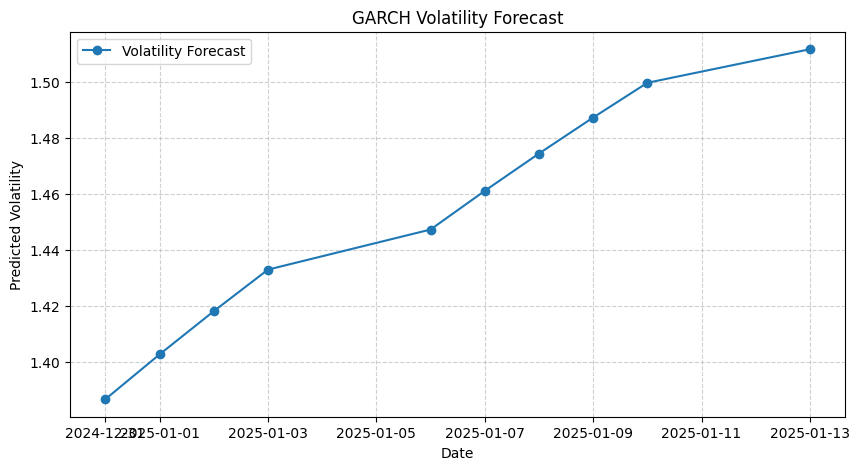

In [41]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Plot
plot_prediction(prediction_formatted)
